In [1]:
import os

# import gdal
import numpy as np
from matplotlib import pyplot as plt
# from mpl_toolkits.basemap import Basemap

import csv
# import glob

import cv2
import geopandas as gp

ModuleNotFoundError: No module named 'geopandas'

In [ ]:
home = os.environ['HOME']
KENYA_IMAGES_PATH = os.path.join(os.path.sep, home, 'cs325b', 'roadtype', 'kenya_road_images')
PERU_IMAGES_PATH = os.path.join(os.path.sep, home, 'cs325b', 'roadtype', 'peru_road_images')
ROADTYPE_PATH = os.path.join(os.path.sep, home, 'cs325b', 'roadtype')

PERU_LOCAL_IMAGES_PATH = os.path.join(os.path.sep, home, 'cs325b', 'local_images', 'peru')
KENYA_LOCAL_IMAGES_PATH = os.path.join(os.path.sep, home, 'cs325b', 'local_images', 'kenya')

In [217]:
# kenya_dbf_csv = os.path.join(os.path.sep, home, 'cs325b', 'extra_data', 'kenya_dbf.csv')
# peru_dbf_csv = os.path.join(os.path.sep, home, 'cs325b', 'extra_data', 'peru_dbf.csv')

kenya_shp = gp.read_file('/home/BenChoi/cs325b/data/kenya/kenya_roads.shp')

# kenya_shp = gp.read_file('/home/BenChoi/cs325b/extra_data/kenya_rds_filtered/kenya_rds_filtered.shp')
# peru_shp = gp.read_file('/home/BenChoi/cs325b/extra_data/peru_rds_filtered/peru_rds_filtered.shp')

extra_data = os.path.join(os.path.sep, home, 'cs325b', 'extra_data')

class_key = {'motorway': 'major', 'trunk': 'major', 'primary': 'major', 'secondary': 'major', 
             'motorway_link': 'major', 'trunk_link': 'major', 'primary_link': 'major', 'secondary_link': 'major',
             'tertiary': 'minor', 'unclassified': 'minor', 'tertiary_link': 'minor',
             'track': 'two-track'}

# print(class_key)

def shp_read(shp):
    dict_roadtypes = {}
    line_count = 1
    for idx, el in enumerate(shp['highway']):
        if el  in class_key.keys():
            dict_roadtypes[float(line_count)] = {'roadtype': class_key[el], 'name': shp['name'][idx]}
            line_count += 1
    print(f'Processed {line_count - 1} lines.')
    return dict_roadtypes

kenya_dict = shp_read(kenya_shp)
# peru_dict = shp_read(peru_shp)


Processed 172165 lines.
Processed 97401 lines.


In [218]:
# def dbf_csv_read(file):
#     dict_roadtypes = {}
#     with open(file) as csv_file:
#         csv_reader = csv.reader(csv_file, delimiter=',')
#         line_count = 0
#         for row in csv_reader:
#             if line_count == 0:
#                 print(f'Column names are {", ".join(row)}')
#                 line_count += 1
#             elif row[2] == 'major' or row[2] == 'minor' or row[2] == 'two-track':
# #                 dict_roadtypes[int(row[0])] = {'roadtype': row[2]}
#                 dict_roadtypes[float(line_count)] = {'roadtype': row[2], 'name': row[1]}
#     #             print(f'\t{row[0]}, {row[1]}, {row[2]}.')
#                 line_count += 1
#         print(f'Processed {line_count - 1} lines.')
#     return dict_roadtypes
                      
# kenya_dict = dbf_csv_read(kenya_dbf_csv)
# peru_dict = dbf_csv_read(peru_dbf_csv)
                      
kenya_bbox_csv = os.path.join(os.path.sep, ROADTYPE_PATH, 'kenya_roads_bbox_300m.csv')
peru_bbox_csv = os.path.join(os.path.sep, ROADTYPE_PATH, 'peru_roads_bbox_300m.csv')

kenya_id_dict = {}
peru_id_dict = {}

def kenya_bbox_csv_read(file, dict_roadtypes):
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                line_count += 1
            else:
                dict_roadtypes[float(row[1])]['lat'] = float(row[4])
                dict_roadtypes[float(row[1])]['lon'] = float(row[3])
                if not float(row[2]) in kenya_id_dict.keys():
                    kenya_id_dict[float(row[2])] = float(row[1])
    #             print(f'\t{row[0]}, {row[1]}, {row[2]}.')
                line_count += 1
        print(f'Processed {line_count - 1} lines.')
    return dict_roadtypes

def peru_bbox_csv_read(file, dict_roadtypes):
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                line_count += 1
            elif float(row[2]) % 2 == 0:
                dict_roadtypes[float(row[2]) / 2]['lat'] = (float(row[4]) + float(row[6])) / 2
                dict_roadtypes[float(row[2]) / 2]['lon'] = float(row[3])
                peru_id_dict[float(row[1])] = float(row[2]) / 2
    #             print(f'\t{row[0]}, {row[1]}, {row[2]}.')
                line_count += 1
        print(f'Processed {line_count - 1} lines.')
    return dict_roadtypes
                      
kenya_dict = kenya_bbox_csv_read(kenya_bbox_csv, kenya_dict)
peru_dict = peru_bbox_csv_read(peru_bbox_csv, peru_dict)
                      
kenya_major_lat = []
kenya_major_lon = []
kenya_minor_lat = []
kenya_minor_lon = []
kenya_two_track_lat = []
kenya_two_track_lon = []

peru_major_lat = []
peru_major_lon = []
peru_minor_lat = []
peru_minor_lon = []
peru_two_track_lat = []
peru_two_track_lon = []


for value in kenya_dict.items():
    if value[1]['roadtype'] == 'major':
        kenya_major_lat.append(value[1]['lat'])
        kenya_major_lon.append(value[1]['lon'])
    elif value[1]['roadtype'] == 'minor':
        kenya_minor_lat.append(value[1]['lat'])
        kenya_minor_lon.append(value[1]['lon'])
    elif value[1]['roadtype'] == 'two-track':
        kenya_two_track_lat.append(value[1]['lat'])
        kenya_two_track_lon.append(value[1]['lon'])
        
for value in peru_dict.items():
    if value[1]['roadtype'] == 'major':
        peru_major_lat.append(value[1]['lat'])
        peru_major_lon.append(value[1]['lon'])
    elif value[1]['roadtype'] == 'minor':
        peru_minor_lat.append(value[1]['lat'])
        peru_minor_lon.append(value[1]['lon'])
    elif value[1]['roadtype'] == 'two-track':
        peru_two_track_lat.append(value[1]['lat'])
        peru_two_track_lon.append(value[1]['lon'])

Column names are , index, id, lon, lat, minLat, maxLat, minLon, maxLon
Processed 172165 lines.
Column names are system:index, id, index, lon, maxlat, maxlon, minlat, minlon, .geo
Processed 97401 lines.


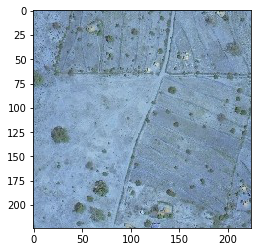

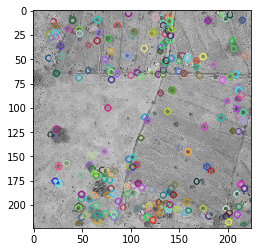

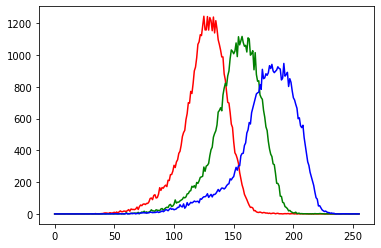

Mean value per band: [125.56919642857143, 152.7735371492347, 178.00284996811226]


In [219]:
# FEATURE EXTRACTION METHODS

def get_sift_keypoints(im, plot=False):
    gray= cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(gray,None)
    if plot:
        img=cv2.drawKeypoints(gray,kp, outImage=np.array([]))
        plt.imshow(img)
    return kp

def get_hog(im):
    hog = cv2.HOGDescriptor()
    h = hog.compute(im)
    return h

def get_color_hist(im):
    channels = cv2.split(im)
    colors = ["r", "g", "b"]
    features = []
    for (channel, color) in zip(channels, colors):
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        # plot the histogram
        # plt.plot(hist, color = color)
        # plt.xlim([0, 256])
        features.append(hist)
    return features

def mean_value_per_band(im):
    mean = []
    for channel in cv2.split(im):
        mean.append(np.mean(channel))
    return mean
    
    
#---------------------------------------------------------------------------
    
    
img_path = KENYA_LOCAL_IMAGES_PATH + '/485289_kenya_resized.jpg'
im = cv2.imread(img_path)

plt.imshow(im)

plt.show()

get_sift_keypoints(im, plot=True)

plt.show()

plt.plot(get_color_hist(im)[0], color='r')
plt.plot(get_color_hist(im)[1], color='g')
plt.plot(get_color_hist(im)[2], color='b')

plt.show()

print("Mean value per band: " + str(mean_value_per_band(im)))

In [220]:
import random

paths = os.listdir(KENYA_LOCAL_IMAGES_PATH)

# Getting paths of images that are labeled as major, minor, and two-track.
major_paths = []
minor_paths = []
two_paths = []

for path in paths:
    roadtype = kenya_dict[kenya_id_dict[float(path.split('_')[0])]]['roadtype']
    if roadtype == 'major':
        major_paths.append(path)
    elif roadtype == 'minor':
        minor_paths.append(path)
    elif roadtype == 'two-track':
        two_paths.append(path)

        
# Getting a random sample of 1200 and 300 images respectively from each class for train/test.
random.shuffle(major_paths)
random.shuffle(minor_paths)
random.shuffle(two_paths)
        
train_size = 1200
test_size = 300
    
train_paths = major_paths[:train_size] + minor_paths[:train_size] + two_paths[:train_size]
test_paths = major_paths[-test_size:] + minor_paths[-test_size:] + two_paths[-test_size:]

X_train = np.empty((train_size * 3, 3), dtype='uint8')
X_test = np.empty((test_size * 3, 3), dtype='uint8')


# Here's an example of using feature extraction methods from above and adding it to
# my X_train numpy array.
for idx, path in enumerate(train_paths):
    X_train[idx, :] = mean_value_per_band(cv2.imread(KENYA_LOCAL_IMAGES_PATH + '/' + path))
    
for idx, path in enumerate(test_paths):
    X_test[idx, :] = mean_value_per_band(cv2.imread(KENYA_LOCAL_IMAGES_PATH + '/' + path))

print(X_train.shape)
print(X_test.shape)

y_train = []
y_test = []

# Creating y_train/test by turning labels into 0, 1, or 2 for the three classes.
for path in train_paths:
    roadtype = kenya_dict[kenya_id_dict[float(path.split('_')[0])]]['roadtype']
    if roadtype == 'major':
        y_train.append(0)
    elif roadtype == 'minor':
        y_train.append(1)
    elif roadtype == 'two-track':
        y_train.append(2)
        
for path in test_paths:
    roadtype = kenya_dict[kenya_id_dict[float(path.split('_')[0])]]['roadtype']
    if roadtype == 'major':
        y_test.append(0)
    elif roadtype == 'minor':
        y_test.append(1)
    elif roadtype == 'two-track':
        y_test.append(2)

(3600, 3)
(900, 3)


In [211]:
from sklearn import datasets, linear_model, svm
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

from sklearn.decomposition import PCA
from sklearn import preprocessing

from sklearn import tree
from sklearn import ensemble

from sklearn.neighbors import KNeighborsClassifier

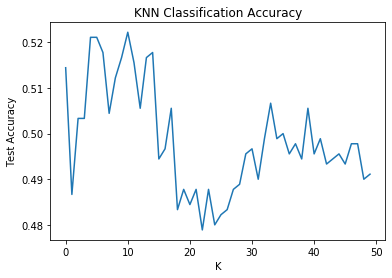

In [224]:
# Fits and tests various classifiers

def test_classifier(classifier, X_train, y_train, X_test, y_test, print=True):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    if print:
        print("R^2: " + str(r2_score(y_test, y_pred)))
        print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
    return classifier, accuracy_score(y_test, y_pred)

# Various classifiers of interest implemented by SKLearn
log_classifier = linear_model.LogisticRegression()
svm_classifier = svm.SVC(kernel='rbf')
K = 6
k_classifier = KNeighborsClassifier(K)
tree_classifier = tree.DecisionTreeClassifier()
rf_classifier = RandomForestClassifier()
boost_classifier = ensemble.GradientBoostingClassifier()

acc = []

for K in range(1, 51):
    k_classifier = KNeighborsClassifier(K)
    classifier, accuracy = test_classifier(k_classifier, X_train, y_train, X_test, y_test, False)
    acc.append(accuracy)
    
plt.plot(acc)
plt.title('KNN Classification Accuracy')
plt.xlabel('K')
plt.ylabel('Test Accuracy')
plt.show()

# import statsmodels.api as sm
# wow = sm.add_constant(X_train)
# model = sm.OLS(y_train, wow).fit()
# model.summary()

In [ ]:
# PCA (feel free to ignore)

pca = PCA(3)

pca = pca.fit(X_train)

k_major_projected = pca.fit_transform(X_train[:1200])
k_minor_projected = pca.fit_transform(X_train[1200:2400])
k_two_projected = pca.fit_transform(X_train[2400:])

plt.scatter(k_major_projected[:, 0], k_major_projected[:, 1])
plt.scatter(k_minor_projected[:, 0], k_minor_projected[:, 1])
plt.scatter(k_two_projected[:, 0], k_two_projected[:, 1])

plt.title('Kenya')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.show()

plt.plot([1, 2, 3], np.cumsum(pca.explained_variance_ratio_))
plt.xticks([1,2,3])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
